In [1]:
import gym

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

from tqdm.notebook import tqdm

#### Окружение крестики-нолики

In [2]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows, n_cols, n_win):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [3]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [4]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            # ходят крестики
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            # ходят нолики
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

#### Off-policy TD control "Q learning"

In [31]:
class TDcontrol():
    def __init__(self, env_tictactoe, epsilon, alpha, gamma):
        self.env = env_tictactoe
        
        self.n_actions = self.env.n_rows * self.env.n_cols
        # и для крестиков и для ноликов один Q
        self.Q = {}
        
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma 
            
    def set(self,):
        pass
    
    def train(self, episods, show_plots = False):        
        if show_plots:
            game_size = 500
            batch_size = 1000 if episods<500000 else 10000
            batch_count = episods//batch_size
            episods = []
            cross_rewards = [] 
            zeros_rewards = []  


            for index_batch in range(batch_count):
                self.__trainloop(batch_size, disable_tqdm=True)
                # крестики по стратегии, нолики по рандому
                cross_reward, zeros_reward = self.game(game_size, disable_tqdm=True)
                # графики
                episods.append((index_batch+1)*batch_size)
                cross_rewards.append(cross_reward)
                zeros_rewards.append(zeros_reward)
                clear_output(True)
                plt.figure(figsize=(16, 5))
                plt.xlabel('Количество эпизодов обучения')
                plt.ylabel(f'Средняя награда расчитанная по {game_size} партиям.')
                plt.plot(episods, cross_rewards, linewidth=1)
                #plt.plot(episods[8:], zeros_rewards[8:], linewidth=1)
                plt.show()
               
        else:
            self.__trainloop(episods)

    
    
    def game(self, episods, player1_random = False, player2_random = True, disable_tqdm=False):        
        reward1 = 0
        reward2 = 0
        #nowinner = 0

        for _ in tqdm(range(episods),desc="GAMING", disable=disable_tqdm):
            self.env.reset()
            done = False
            while not(done):
                # крестики
                state, actions,_ = self.env.getState()
                if player1_random:
                    action = actions[np.random.randint(0,len(actions))]
                else:                    
                    action = self.pi(state)
                _, reward, done, _ = self.env.step(action)
                if done:
                    if reward==-10:
                        reward=0
                    reward1+=reward
                    break
                
                # нолики
                state, actions, _ = self.env.getState()
                if player2_random:
                    action = actions[np.random.randint(0,len(actions))]
                else:                    
                    action = self.pi(state)
                _, reward, done, _ = self.env.step(action)
                if done:
                    if reward==-10:
                        reward=0
                    reward2+=(-reward)
                    break  
            
        return float(reward1)/episods, float(reward2)/episods

                
    def pi(self, state):
        if not state in self.Q:
            actions = self.env.getEmptySpaces()
            return actions[np.random.randint(0,len(actions))]
        return self.env.action_from_int(np.argmax(self.Q[state]))
        
    def __get_action(self, state):
        actions = self.env.getEmptySpaces()
        if not state in self.Q:
            return actions[np.random.randint(0,len(actions))]
        if np.random.uniform(0,1)<self.epsilon:
            return actions[np.random.randint(0,len(actions))]
        else:
            return self.env.action_from_int(np.argmax(self.Q[state]))
        
    def __update_Q(self, state, action, reward, state_new):
        if not state in self.Q:
            self.Q[state]=np.zeros(self.n_actions)
        if not state_new in self.Q:
            self.Q[state_new]=np.zeros(self.n_actions)
            
        action_int = self.env.int_from_action(action)
        self.Q[state][action_int] = self.Q[state][action_int] + self.alpha*(reward + self.gamma*np.max(self.Q[state_new]) - self.Q[state][action_int])
        
        
    def __trainloop(self, iterations, disable_tqdm=False):
        for _ in tqdm(range(iterations),desc="TRAINING", disable=disable_tqdm):
            self.env.reset()              
            done = False
            
            # initialization
            state_cross = self.env.getHash()
            action_cross = self.__get_action(state_cross)
            _, reward, done, _ = self.env.step(action_cross)
            
            state_zero = self.env.getHash()
            action_zero = self.__get_action(state_zero)
            _, reward, done, _ = self.env.step(action_zero)
            
            if reward == -10:
                self.__update_Q(state_cross, action_cross, reward, self.env.getHash())
            

            while not(done):
                # крестики
                state_cross_new = self.env.getHash()
                self.__update_Q(state_cross, action_cross, reward, state_cross_new)
                
                state_cross = state_cross_new                
                action_cross = self.__get_action(state_cross)
                _, reward, done, _ = self.env.step(action_cross)
                
                if done:
                    state_last = self.env.getHash()
                    if reward == -10:
                        self.__update_Q(state_cross, action_cross, reward, state_last)
                    else:
                        self.__update_Q(state_cross, action_cross, reward, state_last)
                        self.__update_Q(state_zero, action_zero, -reward, state_last)
                    break
                
                # нолики
                state_zero_new = self.env.getHash()
                self.__update_Q(state_zero, action_zero, reward, state_zero_new)
                
                state_zero = state_zero_new
                action_zero = self.__get_action(state_zero)
                _, reward, done, _ = self.env.step(action_zero)
                
                if done:
                    state_last = self.env.getHash()
                    if reward == -10:
                        self.__update_Q(state_zero, action_zero, reward, state_last)
                    else:
                        self.__update_Q(state_cross, action_cross, reward, state_last)
                        self.__update_Q(state_zero, action_zero, -reward, state_last)
                    break
            
                

#### Часть 1
Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

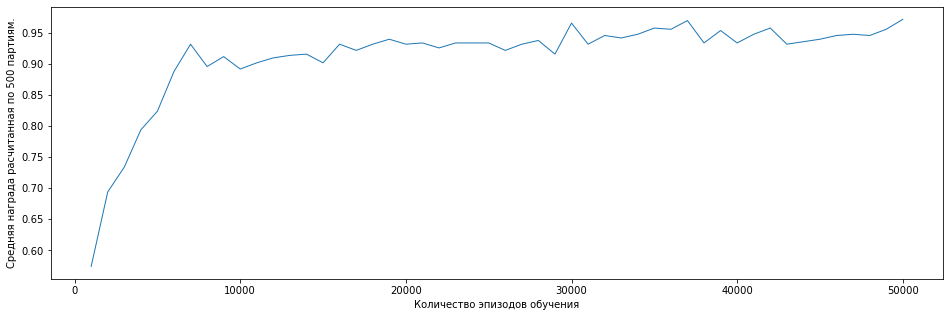

In [32]:
args={
    "env_tictactoe":TicTacToe(n_rows=3, n_cols=3, n_win=3)
    , "epsilon":0.3
    , "alpha":0.003
    , "gamma":1
}
qmodel = TDcontrol(**args)
qmodel.train(episods=50000, show_plots = True)

Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

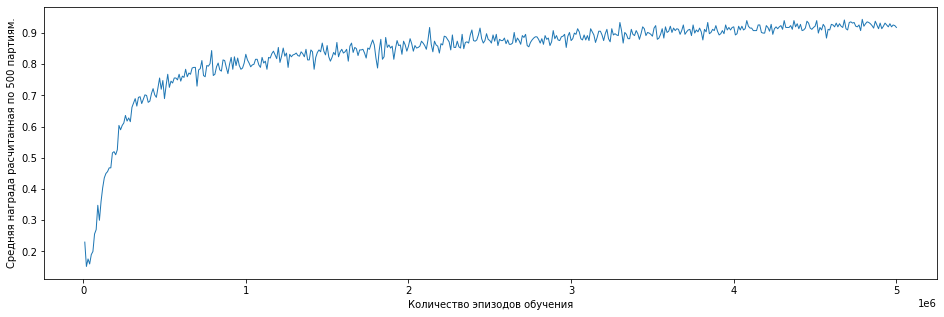

In [33]:
args={
    "env_tictactoe":TicTacToe(n_rows=4, n_cols=4, n_win=4)
    , "epsilon":0.7
    , "alpha":0.007
    , "gamma":1
}
qmodel = TDcontrol(**args)
qmodel.train(episods=5000000, show_plots = True)